In [ ]:
# cnn model and accuracy - ultrasound image dataset
# organize dataset into a useful structure

import os
import tensorflow as tf
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'

from os import makedirs
from os import listdir
from shutil import copyfile
from random import seed
from random import random

# baseline model for the classification dataset
import sys
from matplotlib import pyplot
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from sklearn.model_selection import KFold, StratifiedKFold
from tensorflow.keras.optimizers import SGD
from keras.preprocessing.image import ImageDataGenerator

#!pip install opencv-python
#!pip install lime 

import numpy as np
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from skimage.color import gray2rgb
from skimage.color import rgb2gray
from tensorflow.keras.preprocessing import image
from tensorflow.keras.applications import inception_v3 as inc_net
from lime import lime_image
import pandas as pd
import glob
from tensorflow.keras.models import load_model
from sklearn.metrics import r2_score
from cv2 import cv2
from keras.preprocessing.image import ImageDataGenerator
from skimage.segmentation import mark_boundaries

In [ ]:
# create directories - data preparation
dataset_home = 'markers_dataset_trial/'
subdirs = ['train/', 'test/']
for subdir in subdirs:
	# create label subdirectories
	labeldirs = ['with/', 'without/']
	for labldir in labeldirs:
		newdir = dataset_home + subdir + labldir
		makedirs(newdir, exist_ok=True)
        
# seed random number generator
seed(1)
# define ratio of pictures to use for validation
val_ratio = 0.2

# copy training dataset images into subdirectories
src_directory = 'all_images/'
for file in listdir(src_directory):
	src = src_directory + '/' + file
	dst_dir = 'train/'
	if random() < val_ratio:
		dst_dir = 'test/'
	if file.startswith('bad'):
		dst = dataset_home + dst_dir + 'without/'  + file
		copyfile(src, dst)
	elif file.startswith('gs'):
		dst = dataset_home + dst_dir + 'with/'  + file
		copyfile(src, dst)

In [ ]:
# plot diagnostic learning curves
def summarize_diagnostics(fold_no, history):
	# plot loss
	pyplot.subplot(211)
	pyplot.title('Cross Entropy Loss:'+str(fold_no))
	pyplot.plot(history.history['loss'], color='blue', label='train'+str(fold_no))
	#pyplot.plot(history.history['val_loss'], color='orange', label='test')
	pyplot.xlabel("Epochs")
	pyplot.ylabel("Loss")
	pyplot.legend()
    
	# plot accuracy
	pyplot.subplot(212)
	pyplot.title('Classification Accuracy:'+str(fold_no))
	pyplot.plot(history.history['accuracy'], color='blue', label='train'+str(fold_no))
	#pyplot.plot(history.history['val_accuracy'], color='orange', label='test')
	pyplot.xlabel("Epochs")
	pyplot.ylabel("Accuracy")
	pyplot.legend()
    # set the spacing between subplots
	pyplot.subplots_adjust(left=0.1, bottom=0.1, right=0.9, top=0.9, wspace=0.4, hspace=0.7)
	# save plot to file
	# filename = sys.argv[0].split('/')[-1]
	# pyplot.savefig(filename + '_plot_new.png')
	pyplot.savefig('CNN_model_accuracy_plot_'+str(fold_no)+'.png')
	pyplot.close()

In [ ]:
# datagen = ImageDataGenerator(rescale=1.0/255.0)
# # prepare iterators
train_it = datagen.flow_from_directory('markers_dataset_trial/train/',
    class_mode='binary', batch_size=150, target_size=(350, 350))
test_it = datagen.flow_from_directory('markers_dataset_trial/test/',
    class_mode='binary', batch_size=150, target_size=(350, 350))
X_train, y_train = train_it.next()
X_test, y_test = test_it.next()
LX = np.vstack((X_train,X_test))
LY = np.hstack((y_train,y_test))
np.save('markers_dataset_trial/LX.npy',LX)
np.save('markers_dataset_trial/LY.npy',LY)


# Define the K-fold Cross Validator
kfold = KFold(n_splits=10, shuffle=True)

# K-fold Cross Validation model evaluation
fold_no = 1
train_acc_per_fold = []
train_loss_per_fold = []
val_acc_per_fold = []
val_loss_per_fold = []
test_acc_per_fold = []
test_loss_per_fold = []

for train, val in kfold.split(X_train, y_train):
    # Define the model architecture
    model = Sequential()
    model.add(Conv2D(32, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same', input_shape=(350, 350, 3)))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(64, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Conv2D(128, (3, 3), activation='relu', kernel_initializer='he_uniform', padding='same'))
    model.add(MaxPooling2D((2, 2)))
    model.add(Flatten())
    model.add(Dense(128, activation='relu', kernel_initializer='he_uniform'))
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile the model
    opt = SGD(lr=0.001, momentum=0.9)
    model.compile(loss='binary_crossentropy', optimizer=opt,metrics=['accuracy'])
    model.save('marker_model_fold_no_'+ str(fold_no) +'.h5')
    
    # Generate a print
    print('------------------------------------------------------------------------')
    print(f'Training for fold {fold_no} ...')

    # Fit data to model
    history = model.fit(X_train[train], y_train[train], batch_size=150, epochs=50, verbose=0)
    #train_acc_per_fold.append(history.history['accuracy'])
    #train_loss_per_fold.append(history.history['loss'])
    #summarize_diagnostics(fold_no, history)
    
    # Generate generalization metrics
    train_scores = model.evaluate(X_train[train], y_train[train], verbose=0)
    print(f'Train Score for fold {fold_no}: {model.metrics_names[0]} of {train_scores[0]}; {model.metrics_names[1]} of {train_scores[1]*100}%')
    train_acc_per_fold.append(train_scores[1] * 100)
    train_loss_per_fold.append(train_scores[0])
    
    val_scores = model.evaluate(X_train[val], y_train[val], verbose=0)
    print(f'Val Score for fold {fold_no}: {model.metrics_names[0]} of {val_scores[0]}; {model.metrics_names[1]} of {val_scores[1]*100}%')
    val_acc_per_fold.append(val_scores[1] * 100)
    val_loss_per_fold.append(val_scores[0])

    test_scores = model.evaluate(X_test, y_test, steps=len(X_test), verbose = 0)
    print(f'Test data Score for fold {fold_no}: {model.metrics_names[0]} of {test_scores[0]}; {model.metrics_names[1]} of {test_scores[1]*100}%')
    test_acc_per_fold.append(test_scores[1] * 100)
    test_loss_per_fold.append(test_scores[0])
    
    # Increase fold number
    fold_no = fold_no + 1

Found 103 images belonging to 2 classes.
Found 20 images belonging to 2 classes.
------------------------------------------------------------------------
Training for fold 1 ...

Train Score for fold 1: loss of 0.096; accuracy of 97.826%
Val Score for fold 1: loss of 0.297; accuracy of 90.909%
Test data Score for fold 1: loss of 0.377; accuracy of 94.999%
------------------------------------------------------------------------
Training for fold 2 ...

Train Score for fold 2: loss of 0.118; accuracy of 97.826%
Val Score for fold 2: loss of 0.897; accuracy of 81.818%
Test data Score for fold 2: loss of 0.559; accuracy of 94.999%
------------------------------------------------------------------------
Training for fold 3 ...

Train Score for fold 3: loss of 0.102; accuracy of 98.913%
Val Score for fold 3: loss of 0.034; accuracy of 100.0%
Test data Score for fold 3: loss of 0.427; accuracy of 94.999%
------------------------------------------------------------------------
Training for fold 4 ...

Train Score for fold 4: loss of 0.047; accuracy of 98.924%
Val Score for fold 4: loss of 0.181; accuracy of 89.999%
Test data Score for fold 4: loss of 0.393; accuracy of 94.999%
------------------------------------------------------------------------
Training for fold 5 ...

Train Score for fold 5: loss of 0.105; accuracy of 97.849%
Val Score for fold 5: loss of 0.057; accuracy of 100.0%
Test data Score for fold 5: loss of 0.396; accuracy of 94.999%
------------------------------------------------------------------------
Training for fold 6 ...

Train Score for fold 6: loss of 0.102; accuracy of 97.849%
Val Score for fold 6: loss of 0.105; accuracy of 100.0%
Test data Score for fold 6: loss of 0.412; accuracy of 94.999%
------------------------------------------------------------------------
Training for fold 7 ...

Train Score for fold 7: loss of 0.045; accuracy of 100.0%
Val Score for fold 7: loss of 0.083; accuracy of 100.0%
Test data Score for fold 7: loss of 0.467; accuracy of 94.999%
------------------------------------------------------------------------
Training for fold 8 ...

Train Score for fold 8: loss of 0.149; accuracy of 96.774%
Val Score for fold 8: loss of 0.137; accuracy of 100.0%
Test data Score for fold 8: loss of 0.375; accuracy of 94.999%
------------------------------------------------------------------------
Training for fold 9 ...

Train Score for fold 9: loss of 0.060; accuracy of 98.924%
Val Score for fold 9: loss of 0.191; accuracy of 80.00%
Test data Score for fold 9: loss of 0.461; accuracy of 89.999%
------------------------------------------------------------------------
Training for fold 10 ...

Train Score for fold 10: loss of 0.076; accuracy of 98.924%
Val Score for fold 10: loss of 0.037; accuracy of 100.0%
Test data Score for fold 10: loss of 0.439; accuracy of 94.999%

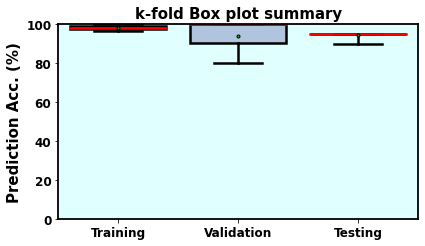

In [6]:
# Box plots of Training, Validation and Testing 

train_acc_per_fold = [97.826, 97.826, 98.913, 98.924, 97.849, 97.849, 100, 96.774, 98.924, 98.924]
val_acc_per_fold = [90.909, 81.818, 100, 89.99, 100, 100, 100, 100, 80, 100]
test_acc_per_fold = [94.99, 94.99, 94.99, 94.99, 94.99, 94.99, 94.99, 94.99, 89.99, 94.99]

import matplotlib.pyplot as plt
import numpy as np
bx_plot_loss_data = [train_acc_per_fold, val_acc_per_fold, test_acc_per_fold]
fig = plt.figure(figsize =(5, 2.7))

data = [train_acc_per_fold, val_acc_per_fold, test_acc_per_fold]
plt.rcParams.update({'font.size': 12, 'font.weight': 'bold'})
plt.rcParams['axes.linewidth'] = 1.8
meanprops = {'marker':'o', #'markerfacecolor':color, 
                'markeredgecolor':'black', 'markersize':3.0, 'linewidth':2.5}
medianprops = {'linestyle':'-', 'linewidth':2.5, 'color':'red'}
boxprops = {'facecolor':'lightsteelblue', 'color':'black', 'linewidth':2.5}
flierprops = {'marker':'o', 'markerfacecolor':'black', 'markersize':1, 'markeredgecolor':'black'}
whiskerprops = {'linewidth':2.5}
capprops = {'linewidth':2.5}
    
# Creating axes instance
ax = fig.add_axes([0, 0, 1, 1])
# Creating plot
bp = plt.boxplot(
                    data, #positions=positions, 
                    widths=0.8, #(1, 1, 1),
                    whis=(0,100),               # Percentiles for whiskers
                    showmeans=True,             # Show means in addition to median
                    patch_artist=True,          # Fill with color
                    meanprops=meanprops,        # Customize mean points
                    medianprops=medianprops,    # Customize median points
                    boxprops=boxprops,
                    showfliers=False,            # Show/hide points beyond whiskers            
                    flierprops=flierprops,
                    whiskerprops=whiskerprops,
                    capprops=capprops
                    )

#ax.tick_params(axis='both', which='major', labelsize=10)
ax.set_ylim([0, 100])
fontsize = 15
fontweight = 'bold'
fontproperties = {'weight' : fontweight, 'size' : fontsize}
ax.set_xticklabels(['Training','Validation', 'Testing'])
# ax.set_xticklabels(ax.get_xticks(), fontproperties)
# ax.set_yticklabels(ax.get_yticks(), fontproperties)
ax.set_facecolor('lightcyan')
#ax.set_yticks(np.arange(0, 100, step=10))
plt.ylabel('Prediction Acc. (%)', fontweight='bold', fontsize = 15)
plt.title('k-fold Box plot summary', fontweight='bold', fontsize = 15)
# show plot
plt.show()


In [ ]:
## LIME ANALYSIS
## Import required libraries / packages

import numpy as np
from tensorflow.keras import backend as K
import matplotlib.pyplot as plt
import math
import scipy
import scipy.io
from PIL import Image
from scipy import ndimage
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras.layers import Conv2D, MaxPooling2D
from tensorflow.keras.utils import plot_model
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.utils import to_categorical
import tensorflow as tf
# import tensorflow_addons as tfa

import pydot
import pydotplus
import graphviz
from tensorflow.keras.preprocessing.image import load_img
from tensorflow.keras.preprocessing.image import img_to_array
from tensorflow.keras.models import Model
import random
from keras.models import load_model
import pickle
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import glob
import os
import pandas as pd

import types
from lime.utils.generic_utils import has_arg
from skimage.segmentation import felzenszwalb, slic, quickshift
import copy
from functools import partial

import sklearn
import sklearn.preprocessing
from sklearn.utils import check_random_state
from skimage.color import gray2rgb
from tqdm.auto import tqdm

import scipy.ndimage as ndi
from skimage.segmentation._quickshift_cy import _quickshift_cython

from lime import lime_base
from lime.wrappers.scikit_image import SegmentationAlgorithm

import skimage
from matplotlib import colors
from skimage.segmentation import mark_boundaries, find_boundaries
from skimage.morphology import dilation,square
from collections import Counter

In [ ]:
# LIME Analysis

LX = np.load('markers_dataset_trial/LX.npy')
LY = np.load('markers_dataset_trial/LY.npy')

model = load_model('marker_model_fold_no_3.h5')
pred = model.predict(LX)

pred_class = [1 if a < 0.5 else 0 for a in pred]
correct_X_ind = list(np.where(pred_class==LY)[0])


import lime
from lime import lime_image
from matplotlib import pyplot as plt
fname_out = 'C:\\Users\\data_and_code_Dec31\\Shallow_markers'

seg_fn = 'quickshift'
if seg_fn == 'quickshift':
    k_size = 5   # number of s-pixels
    num_s = 100   # number of perturbed samples
elif seg_fn == 'slic': 
    k_size = 200
    num_s = 400
    
explainer = lime_image.LimeImageExplainer()
score = []
# Input the sample_index corresponding to every image (from 1 to 123)
for sample_ind in correct_X_ind:

# sample_ind = 27
    sample = LX[sample_ind, :, :, :].astype('double')
    y_samp = LY[sample_ind]     # Change accordingly for different seg_fn
    explanation = explainer.explain_instance(sample, model, top_labels=2, hide_color=0, num_samples=num_s, num_features = k_size)
    score.append(explanation.score)

    if explanation.score > 0.75 and explanation.score <= 1:
        temp, mask = explanation.get_image_and_mask(explanation.top_labels[0], positive_only=False, num_features = k_size, hide_rest=False)
        plt.figure(figsize = (12,8))
        plt.subplot(1, 2, 1)
        plt.imshow(sample)
        plt.subplot(1, 2, 2)
        plt.imshow(mark_boundaries(temp / 2 + 0.5, mask))
        if y_samp == 0:
          plt.suptitle('No marker',fontsize= 14, fontweight = 'bold')
        else:
          plt.suptitle('With marker',fontsize= 14, fontweight = 'bold')
        plt.savefig(fname_out+'\\local results\\'+str(sample_ind)+'_LIME_topten_plot.png',dpi = 400)
        plt.close()

        # save weights and watershed/lime ratios
        weightRatio = []
        for i, e in explanation.local_exp[explanation.top_labels[0]]:
            weightRatio.append((i, e, explanation.local_pred[explanation.top_labels[0]],explanation.intercept[explanation.top_labels[0]],explanation.top_labels[0]))
  
        WR = pd.DataFrame(weightRatio)
        WR.to_csv(fname_out+ str(sample_ind)+'_weightRatioPred_score'+str(round(explanation.score,2))+'_numseg'+str(len(explanation.local_exp[explanation.top_labels[0]]))+'.csv', index = False)
        
            
score = np.array(score)
np.save(fname_out+'\\'+seg_fn+'kerns'+str(k_size)+'_nums'+str(num_s)+'score.npy',score)